In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import trimesh
from skimage import measure
import meshplot as mp
from torch.utils.data import DataLoader, Dataset
import os
import time
from datetime import timedelta, datetime
import random
import math
import logging

In [74]:
# 4 layer autodecoder MLP class for 10 shapes 
class MLP_4(nn.Module):
    def __init__(self, n_shapes, shape_code_length, n_inner_nodes):
        super(MLP_4, self).__init__()
        self.shape_code_length = shape_code_length
        self.shape_codes = nn.Embedding(n_shapes, shape_code_length, max_norm=0.01) # shape code as an embedding # TODO: take this outside 
        
        self.linear1 = nn.Linear(3 + shape_code_length, n_inner_nodes) # (x, y, z) + shape code 
        self.linear2 = nn.Linear(n_inner_nodes, n_inner_nodes)
        self.linear3 = nn.Linear(n_inner_nodes, n_inner_nodes)
        self.linear4 = nn.Linear(n_inner_nodes, 1)
        
        self.relu = nn.ReLU()

    def forward(self, shape_idx, x):
        shape_code = self.shape_codes(shape_idx.view(1, -1))
        print(shape_code.shape)
        shape_code = shape_code.view(-1, self.shape_code_length)
        shape_code_with_xyz = torch.cat((x, shape_code), dim=1) # concatenate horizontally
        
        out = self.linear1(shape_code_with_xyz)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)

        return out
    

filename = './models/autodecoder_08052022_073446' # trained for 10 shapes
model = MLP_4(10, 256, 256)
model.load_state_dict(torch.load(filename))

shape_codes = model.state_dict()['shape_codes.weight']
print(shape_codes.shape)

torch.Size([10, 256])


In [376]:
shape_codes = np.zeros((100,2))
for i in range(1,100):
    shape_codes[i,: ] =[(shape_codes[i-1,0]+1),(shape_codes[i-1,0]+1)]
shape_codes1 = np.zeros((100,2))
for i in range(1,100):
    shape_codes1[i,: ] =[(shape_codes1[i-1,0]-1),(-shape_codes1[i-1,0]+1)+100]
shape_codes = np.array([shape_codes/10,shape_codes1/10])
#shape_codes = np.hstack((shape_codes,shape_codes))
#shape_codes = np.hstack((shape_codes,shape_codes))
shape_codes = torch.tensor(shape_codes)
#shape_codes

In [30]:
class DecoderPartial(nn.Module):
    def __init__(self,shape_code_length, n_inner_nodes):
        super(DecoderPartial, self).__init__()
        self.shape_code_length = shape_code_length
        self.linear1 = nn.Linear(3 + shape_code_length, n_inner_nodes) # (x, y, z) + shape code 
        self.linear2 = nn.Linear(n_inner_nodes, n_inner_nodes)
        self.linear3 = nn.Linear(n_inner_nodes, n_inner_nodes)
        self.linear4 = nn.Linear(n_inner_nodes, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self,shape_code, x):
        shape_code = shape_code.repeat([1000000,1])
        print(shape_code.size())
        shape_code = shape_code.view(-1, self.shape_code_length)
        shape_code_with_xyz = torch.cat((x, shape_code), dim=1) # concatenate horizontally
        out = self.linear1(shape_code_with_xyz)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)

        return out

In [31]:
mod = DecoderPartial(256,256)
#mod_dict = mod.state_dict()
mod.load_state_dict(torch.load(filename),strict=False)
mod.eval()
#for param_tensor in mod.state_dict():
    #print(param_tensor, "\t", mod.state_dict()[param_tensor])
# 1. filter out unnecessary keys
#pretrained_dict = {k: v for k, v in model.iteritems() if k in model_dict}
# 2. overwrite entries in the existing state dict
#model_dict.load_state_dict(pretrained_dict) 
# 3. load the new state dict
#model.load_state_dict(pretrained_dict)

DecoderPartial(
  (linear1): Linear(in_features=259, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Diffusion

In [377]:
dataset = shape_codes

In [378]:
dataset.shape

torch.Size([2, 100, 2])

In [209]:
std = np.std(np.asarray(dataset))
mean = np.mean(np.asarray(dataset))

In [210]:
mean

127.5

In [211]:
dataset = (dataset-mean)/(std)

In [9]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [272]:
n_steps = 1000
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-2, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [12]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [13]:
def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [14]:
x = np.linspace(-1, 1, 100, dtype=np.float32)
y = np.linspace(-1, 1, 100, dtype=np.float32)
z = np.linspace(-1, 1, 100, dtype=np.float32)
P = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1).T  # format: [[x1, y1, z1], [x1, y1, z2], [] ...]
P = torch.from_numpy(P)

# inferring
q=std*dataset[6,:]+mean
volume = mod(q,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
volume = volume.detach().numpy()
verts, faces, normals, values = measure.marching_cubes(volume, 0)
mp.plot(verts, faces)

for i in range(100):
    q_i = std*q_sample(dataset[6,:], torch.tensor([i]))+mean
shape_idx_tensor = torch.ones((P.shape[0], 1), dtype=torch.int) * shape_idx

# inferring
volume = mod(q_i,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
volume = volume.detach().numpy()
verts, faces, normals, values = measure.marching_cubes(volume, 0)
mp.plot(verts, faces)

NameError: name 'mod' is not defined

In [47]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [16]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [17]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps, temb_ch):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        # self.embed = nn.Embedding(n_steps, num_out)
        # self.embed.weight.data.uniform_()

        self.temb_proj = torch.nn.Linear(temb_ch,
                                         num_out)
        self.nonlin = torch.nn.SiLU()


    def forward(self, x, y):
        out = self.lin(x)

        out = self.temb_proj(self.nonlin(y)) + out
        return out

In [252]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps, ch=32, num_out=64):
        super(ConditionalModel, self).__init__()
        self.ch = ch
        self.temb_ch = ch * 4
        self.lin1 = ConditionalLinear(2,128, n_steps, self.temb_ch)
        self.lin2 = ConditionalLinear(128,128, n_steps, self.temb_ch)
        self.lin3 = nn.Linear(128,2)


        # timestep embedding
        self.temb = nn.Sequential(
            torch.nn.Linear(ch,
                            self.temb_ch),
            torch.nn.SiLU(),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        )

    
    def forward(self, x, y):
        y = get_timestep_embedding(y, self.ch)
        temb = self.temb(y)
        x = F.softplus(self.lin1(x, temb))
        x = F.softplus(self.lin2(x, temb))
        return self.lin3(x)

def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [19]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [20]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

In [21]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

In [292]:
b=[]
for i in range(n_steps):
    f=torch.randn_like(dataset[0,:,:])
    #for k in range(2):
    b.append(f[None,:,:])
e = torch.Tensor(n_steps,100, 2)
torch.cat(b, out=e)
e.size()

torch.Size([1000, 100, 2])

In [328]:
def noise_estimation_loss(model, x_0,noise_steps,h):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0,n_steps, size=(batch_size//2+1,)) # pick (batch_size//2+1) number of rand integers in bw 0 and n_steps
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long() # pick other time index symmetrically
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    #e = torch.randn_like(x_0)
    e = noise_steps[t,:,:]
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    loss = (e - output).square().mean()
    if loss>0.15 and h>50000:
        print(t)
    return loss


In [25]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow


    def load_state_dict(self, state_dict):
        self.shadow = state_dict

In [379]:
model = ConditionalModel(n_steps)
optimizer = torch.optim.Adam(model.parameters(),betas = (0.9, 0.9),
eps = 1e-08 * 10, lr=1e-3)
#dataset = torch.tensor(data.T).float()
dataset = dataset.float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 1

In [31]:
logging.basicConfig(filename = 'log_file_new.log',
                level = logging.DEBUG,
                format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')
logging.debug("Epoch  Loss ")

In [380]:
for t in range(10000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,e,t)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    #logging.debug("Epoch %d Loss %f",t,loss)
    if (t % 1000 == 0):
        print(loss)

tensor(1.0490, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [52]:
# prepare points to use in inferring
x = np.linspace(-1, 1, 100, dtype=np.float32)
y = np.linspace(-1, 1, 100, dtype=np.float32)
z = np.linspace(-1, 1, 100, dtype=np.float32)
P = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1).T  # format: [[x1, y1, z1], [x1, y1, z2], [] ...]
P = torch.from_numpy(P)

In [381]:
loss

tensor(0.0043, grad_fn=<MeanBackward0>)

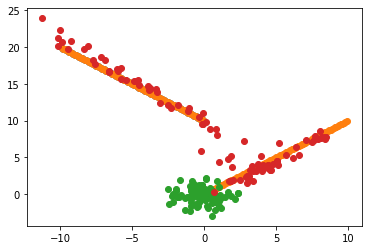

In [388]:
x_0 = dataset[1,:,:]
#q=std*x_0[0,:]+mean
#volume = mod(q,P).view(len(x), len(y), len(z)) 
# marching cube to visualize
#volume = volume.detach().numpy()
#verts, faces, normals, values = measure.marching_cubes(volume, 0)
#mp.plot(verts, faces)
t=torch.tensor([999])
a = extract(alphas_bar_sqrt, t, x_0)
# eps multiplier
am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
#e = torch.randn_like(x_0)
# model input
#e.size()
xx = x_0 * a + e[999,:,:] * am1
#q=std*xx[0,:]+mean
#volume = mod(q,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
#volume = volume.detach().numpy()
#verts, faces, normals, values = measure.marching_cubes(volume, 0)
#mp.plot(verts, faces)

#output = model(x, t)
cur_x = xx
for i in reversed(range(1000)):
        cur_x = p_sample(model, cur_x, i)
    #x_seq.append(cur_x)
#q=std*cur_x[0,:]+mean
#volume = mod(q,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
#volume = volume.detach().numpy()
#verts, faces, normals, values = measure.marching_cubes(volume, 0)
#mp.plot(verts, faces)
#print(x_0)
#print("*****")
#print(xx)
#print("*****")
#print(cur_x)
cur_x=cur_x.detach().numpy()
import matplotlib.pyplot as plt
plt.scatter(x_0[:,0],x_0[:,1])
plt.scatter(dataset[:,:,0],dataset[:,:,1])
plt.scatter(xx[:,0],xx[:,1])
plt.scatter(cur_x[:,0],cur_x[:,1])

In [ ]:
x_0 = dataset[:5,:]
q=std*x_0[0,:]+mean
volume = mod(q,P).view(len(x), len(y), len(z)) 
# marching cube to visualize
volume = volume.detach().numpy()
verts, faces, normals, values = measure.marching_cubes(volume, 0)
mp.plot(verts, faces)
t=torch.tensor([600])
a = extract(alphas_bar_sqrt, t, x_0)
# eps multiplier
am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
#e = torch.randn_like(x_0)
# model input
xx = x_0 * a + e * am1
q=std*xx[0,:]+mean
volume = mod(q,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
volume = volume.detach().numpy()
verts, faces, normals, values = measure.marching_cubes(volume, 0)
mp.plot(verts, faces)

#output = model(x, t)
cur_x = xx
for i in reversed(range(600)):
    #for j in range(10):
    cur_x = p_sample(model, cur_x, i)
    #x_seq.append(cur_x)
q=std*cur_x[0,:]+mean
volume = mod(q,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
volume = volume.detach().numpy()
verts, faces, normals, values = measure.marching_cubes(volume, 0)
mp.plot(verts, faces)

torch.Size([1000000, 256])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.827744…

torch.Size([1000000, 256])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.882847…

torch.Size([1000000, 256])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.504834…

In [ ]:
def load_files(all_file_or_not, n_files = 0):
    file_paths = []
    main_dir = '../data/03001627_sdfs/'

    if all_file_or_not: # loading all files
        n_files = 0
        for sub_dir in os.scandir(main_dir):
            if sub_dir.is_dir():
                for file in os.listdir(main_dir + sub_dir.name):
                    file_paths.append(main_dir + sub_dir.name + '/' + file) if file.endswith("sdf_samples.npz") else None
            n_files += 1
            
    else: # loading specific # of files
        for sub_dir in os.scandir(main_dir):
            if sub_dir.is_dir():
                for file in os.listdir(main_dir + sub_dir.name):
                    file_paths.append(main_dir + sub_dir.name + '/' + file) if file.endswith("sdf_samples.npz") else None
            if len(file_paths) == n_files:
                break
    
    print(f'total # of files: {n_files}')
    return file_paths

In [ ]:
shape_idx = 8 #### change this ####

# load model
filename = './models/autodecoder_08052022_073446' # trained for 10 shapes
model = MLP_4(10, 256, 256)
model.load_state_dict(torch.load(filename))
model.state_dict()
#model.state_dict()['shape_codes.weight'].copy_()####new shape code from the diffusion model###)
model.eval()

# prepare points to use in inferring
x = np.linspace(-1, 1, 100, dtype=np.float32)
y = np.linspace(-1, 1, 100, dtype=np.float32)
z = np.linspace(-1, 1, 100, dtype=np.float32)
P = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1).T  # format: [[x1, y1, z1], [x1, y1, z2], [] ...]
P = torch.from_numpy(P)

shape_idx_tensor = torch.ones((P.shape[0], 1), dtype=torch.int) * shape_idx

# inferring
volume = model(shape_idx_tensor,P).view(len(x), len(y), len(z)) 

# marching cube to visualize
volume = volume.detach().numpy()
verts, faces, normals, values = measure.marching_cubes(volume, 0)
mp.plot(verts, faces)

# load shape files
#file_paths = load_files(all_file_or_not=False, n_files = 10)

# compare with ground truth
#mesh = trimesh.load(file_paths[shape_idx].split('sdf_samples.npz')[0] + 'mesh.obj')
#mp.plot(mesh.vertices, mesh.faces, c=np.array([0, 0.9, 0.9]))

torch.Size([1, 1000000, 256])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.495206…